# The DAX "Prophet"

* DAX = German index. Not the ETF named "DAX" (pitfall)
* Data source: FMP (you can use yfinance)


* Purpose of this NB: swing trade support (weeks)
* Model can detect seasonalities

## Data retrieval ($)

We want historical data for our model. 

This isn't free.

In [237]:
from openbb import obb
import os
from dotenv import load_dotenv

def read_api_keys_from_env():
    """
    Read API keys from env
    """
    load_dotenv("api_keys")  # This loads the variables from the file
    
    obb.user.credentials.nasdaq_api_key = os.getenv('NASDAQ_API_KEY') or print("NASDAQ_API_KEY is not set or empty") or None
    obb.user.credentials.fmp_api_key = os.getenv('FMP_API_KEY') or print("FMP_API_KEY is not set or empty") or None
    obb.user.credentials.econdb_api_key = os.getenv('ECONDB_API_KEY') or print("ECONDB_API_KEY is not set or empty") or None
    obb.user.credentials.fred_api_key = os.getenv('FRED_API_KEY') or print("FRED_API_KEY is not set or empty") or None
    obb.user.credentials.intrinio_api_key = os.getenv('INTRINIO_API_KEY') or print("INTRINIO_API_KEY is not set or empty") or None
    obb.user.credentials.polygon_api_key = os.getenv('POLYGON_API_KEY') or print("POLYGON_API_KEY is not set or empty") or None
    
read_api_keys_from_env()

## Data download via Quant APIs

In [31]:
def get_dax_data(symbol : str):

    df_daily = obb.equity.price.historical(symbol = symbol, provider="fmp",start_date="2000-01-01").to_df()
    return df_daily

# https://site.financialmodelingprep.com/index-summary/%5EGDAXI 
# https://de.finance.yahoo.com/quote/%5EGDAXI/ 
df = get_dax_data("^GDAXI") # Not "DAX", which is an ETF

In [32]:
df.tail(1)

open         high          low        close    volume  \
date                                                                       
2024-08-23  18538.86914  18670.44922  18519.28906  18633.09961  41122500   

                vwap    adj_close  unadjusted_volume    change  change_percent  
date                                                                            
2024-08-23  18590.43  18633.09961         41122500.0  94.23047        0.005083

In [33]:
df.head(1)

open         high          low        close    volume  \
date                                                                       
2000-01-03  6961.720215  7159.330078  6720.870117  6750.759766  43072500   

                  vwap    adj_close  unadjusted_volume     change  \
date                                                                
2000-01-03  6876.98665  6750.759766         43072500.0 -210.96045   

            change_percent  
date                        
2000-01-03         -0.0303

In [34]:
df.to_csv("GDAXI_Jan_2k_Aug24.csv")

# Load the data (local file)

* Data is present in the CSV

In [22]:
import pandas as pd


gdax_df = pd.read_csv("GDAXI_Jan_2k_Aug24.csv")

In [23]:
gdax_df.tail(1)

date         open         high          low        close  \
6260  2024-08-23  18538.86914  18670.44922  18519.28906  18633.09961   

        volume      vwap    adj_close  unadjusted_volume    change  \
6260  41122500  18590.43  18633.09961         41122500.0  94.23047   

      change_percent  
6260        0.005083

In [24]:
gdax_df.head(1)

date         open         high          low        close    volume  \
0  2000-01-03  6961.720215  7159.330078  6720.870117  6750.759766  43072500   

         vwap    adj_close  unadjusted_volume     change  change_percent  
0  6876.98665  6750.759766         43072500.0 -210.96045         -0.0303

# We use a Kalman Filter for estimates

This is one feature we will use.

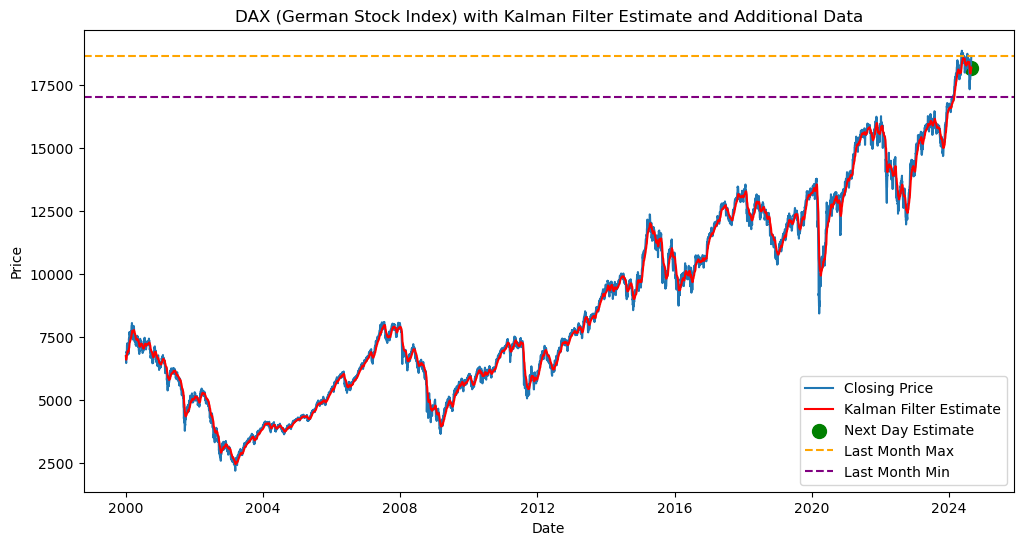

Last 5 days of complete data:
                  close  KalmanEstimate
date                                   
2024-08-20  18357.51953    18083.979993
2024-08-21  18448.94922    18118.697662
2024-08-22  18493.39063    18154.340301
2024-08-23  18633.09961    18199.882243
2024-08-24          NaN    18199.882243

Last complete day in dataset:
open    NaN
high    NaN
low     NaN
close   NaN
Name: 2024-08-24 00:00:00, dtype: float64

Next day estimate: 18199.88
Estimate uncertainty: 0.32

Last month's maximum price: 18670.45

Last month's minimum price: 17024.82

Data range: from 2000-01-03 to 2024-08-24

Current date and time: 2024-08-25 06:54:51.729938


In [5]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# Read the DAX data from the CSV file
df = pd.read_csv("GDAXI_Jan_2k_Aug24.csv", parse_dates=['date'], index_col='date')

# Remove any rows with NaN values and get the latest complete day
df = df.dropna()
latest_complete_day = df.index[-1]

# Ensure we're only working with complete data up to the latest complete day
df = df[:latest_complete_day]

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Apply Kalman Filter
state_means, state_covariances = kf.filter(df['close'])

# Add Kalman Filter estimates to the dataframe
df['KalmanEstimate'] = state_means

# Get the next day estimate
last_mean = state_means[-1]
last_covariance = state_covariances[-1]
next_mean, next_covariance = kf.filter_update(
    filtered_state_mean=last_mean,
    filtered_state_covariance=last_covariance
)

# Add the next day estimate to the dataframe
next_day = latest_complete_day + timedelta(days=1)
df.loc[next_day, 'KalmanEstimate'] = next_mean[0]

# Calculate last month's max and min
last_month_start = latest_complete_day - timedelta(days=30)
last_month = df.loc[last_month_start:]
last_month_max = last_month['high'].max()
last_month_min = last_month['low'].min()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='Closing Price')
plt.plot(df.index, df['KalmanEstimate'], label='Kalman Filter Estimate', color='red')
plt.scatter(next_day, next_mean, color='green', s=100, label='Next Day Estimate')

# Add horizontal lines for last month's max and min
plt.axhline(y=last_month_max, color='orange', linestyle='--', label='Last Month Max')
plt.axhline(y=last_month_min, color='purple', linestyle='--', label='Last Month Min')

plt.title('DAX (German Stock Index) with Kalman Filter Estimate and Additional Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print the last few days of data and the next day estimate
print("Last 5 days of complete data:")
print(df[['close', 'KalmanEstimate']].tail())

print(f"\nLast complete day in dataset:")
print(df[['open', 'high', 'low', 'close']].iloc[-1])

print(f"\nNext day estimate: {next_mean[0]:.2f}")
print(f"Estimate uncertainty: {np.sqrt(next_covariance[0][0]):.2f}")

print(f"\nLast month's maximum price: {last_month_max:.2f}")
print(f"\nLast month's minimum price: {last_month_min:.2f}")

# Print the date range of the data
print(f"\nData range: from {df.index[0].date()} to {df.index[-1].date()}")

print(f"\nCurrent date and time: {datetime.now()}")

# Get foundational features ($)

We are going to enrich our dataset with

* Export stats
* Inflation

https://www.econdb.com/series/REXPDE/germany-real-exports-of-goods-and-services/?from=2019-08-25&to=2024-08-25 

We know DE is exporting a lot, and that DAX companies are export focused.
(For very adv. analysis, we could incorporate the cash flow etc. - all possible)

## RPXDE = Germany - Real exports of goods and services (Level USD)

These statistics aren't available since '91. 
We could go all out and merge certain other stats. But it doesn't seem to be necessary.

In [ ]:
import pandas as pd

API_TOKEN = os.getenv('ECONDB_API_KEY')

export_stats_usd_de_df = pd.read_csv(
    'https://www.econdb.com/api/series/REXPDE~TUSD/?token=%s&format=csv' % API_TOKEN,
    index_col='Date', parse_dates=['Date'])

In [219]:
export_stats_usd_df.tail(1)

REXPDE~TUSD
Date                   
2024-01-01     441754.0

In [217]:
export_stats_usd_df.head(1)

REXPDE~TUSD
Date                   
1991-01-01          NaN

## CPI = Germany - Consumer Price Index (Level USD would be better)

In [32]:
import pandas as pd

consumer_price_index_de_df = pd.read_csv(
    'https://www.econdb.com/api/series/CPIDE/?token=%s&format=csv' % API_TOKEN,
    index_col='Date', parse_dates=['Date'])

In [33]:
consumer_price_index_de_df.head(1)

CPIDE
Date             
2012-03-01   91.7

In [34]:
consumer_price_index_de_df.tail(1)

CPIDE
Date             
2024-07-01  119.8

# Combine the datasets

In [39]:
import pandas as pd


# Ensure export_stats_usd_de_df and consumer_price_index_de_df have datetime index
export_stats_usd_de_df.index = pd.to_datetime(export_stats_usd_de_df.index)
consumer_price_index_de_df.index = pd.to_datetime(consumer_price_index_de_df.index)

# Resample export_stats_usd_de_df to daily frequency and forward fill
export_stats_daily = export_stats_usd_de_df.resample('D').ffill()

# Resample consumer_price_index_de_df to daily frequency and forward fill
cpi_daily = consumer_price_index_de_df.resample('D').ffill()

# Merge all dataframes
combined_df = gdax_df.join([export_stats_daily, cpi_daily], how='outer')

# Forward fill any remaining NaN values
combined_df = combined_df.ffill()

# If you want 'date' as a column instead of index
combined_df = combined_df.reset_index()

# Display the first few rows of the combined dataframe
print(combined_df.tail())

# Display info about the combined dataframe
print(combined_df.info())

           index         open         high          low        close  \
12271 2024-08-19  18312.50977  18454.93945  18284.85938  18421.68945   
12272 2024-08-20  18473.23047  18495.27930  18349.98047  18357.51953   
12273 2024-08-21  18358.78906  18476.63086  18352.18945  18448.94922   
12274 2024-08-22  18459.27930  18551.39063  18458.60938  18493.39063   
12275 2024-08-23  18538.86914  18670.44922  18519.28906  18633.09961   

           volume      vwap    adj_close  unadjusted_volume     change  \
12271  43769700.0  18368.50  18421.68945         43769700.0  109.17968   
12272  42912000.0  18419.00  18357.51953         42912000.0 -115.71094   
12273  36068100.0  18409.14  18448.94922         36068100.0   90.16016   
12274  40950900.0  18490.67  18493.39063         40950900.0   34.11133   
12275  41122500.0  18590.43  18633.09961         41122500.0   94.23047   

       change_percent  REXPDE~TUSD  CPIDE  
12271        0.005962     441754.0  119.8  
12272       -0.006264     441754.0

# Calculation of a volatility-based indicator (Lorentzian) and the Kalman estimation

In [195]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import talib

# Function to calculate Lorentzian indicator
def calculate_lorentzian(data, period=14):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = talib.SMA(true_range, timeperiod=period)
    lorentzian = np.log(1 + atr)
    return lorentzian

# Assuming gdax_df is your DAX data
# Ensure gdax_df has 'date' as index and contains 'open', 'high', 'low', 'close' columns

# Calculate Kalman Filter estimates
kf = KalmanFilter(
    initial_state_mean=gdax_df['close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

state_means, _ = kf.filter(gdax_df['close'])
gdax_df['KalmanEstimate'] = state_means

# Calculate Lorentzian indicator
gdax_df['LorentzianIndicator'] = calculate_lorentzian(gdax_df)

# Ensure export_stats_usd_de_df and consumer_price_index_de_df have datetime index
export_stats_usd_de_df.index = pd.to_datetime(export_stats_usd_de_df.index)
consumer_price_index_de_df.index = pd.to_datetime(consumer_price_index_de_df.index)

# Resample export_stats_usd_de_df to daily frequency and forward fill
export_stats_daily = export_stats_usd_de_df.resample('D').ffill()

# Resample consumer_price_index_de_df to daily frequency and forward fill
cpi_daily = consumer_price_index_de_df.resample('D').ffill()

# Merge all dataframes
combined_df = gdax_df.join([export_stats_daily, cpi_daily], how='outer')

# Forward fill any remaining NaN values
combined_df = combined_df.ffill()

# If you want 'date' as a column instead of index
combined_df = combined_df.reset_index()

# Display the first few rows of the combined dataframe
print(combined_df.tail())

# Display info about the combined dataframe
print(combined_df.info())

           index         open         high          low        close  \
12271 2024-08-19  18312.50977  18454.93945  18284.85938  18421.68945   
12272 2024-08-20  18473.23047  18495.27930  18349.98047  18357.51953   
12273 2024-08-21  18358.78906  18476.63086  18352.18945  18448.94922   
12274 2024-08-22  18459.27930  18551.39063  18458.60938  18493.39063   
12275 2024-08-23  18538.86914  18670.44922  18519.28906  18633.09961   

           volume      vwap    adj_close  unadjusted_volume     change  \
12271  43769700.0  18368.50  18421.68945         43769700.0  109.17968   
12272  42912000.0  18419.00  18357.51953         42912000.0 -115.71094   
12273  36068100.0  18409.14  18448.94922         36068100.0   90.16016   
12274  40950900.0  18490.67  18493.39063         40950900.0   34.11133   
12275  41122500.0  18590.43  18633.09961         41122500.0   94.23047   

       change_percent  KalmanEstimate  LorentzianIndicator  REXPDE~TUSD  CPIDE  
12271        0.005962    18055.224170    

# Now we fit Prophet

## Prophet model for the next day

In [205]:
from prophet import Prophet
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Assuming your dataframe is named combined_df
df = combined_df.copy()

# Convert 'index' to datetime if it's not already
df['index'] = pd.to_datetime(df['index'])

# Filter for the last 10 years of data
ten_years_ago = datetime.now() - timedelta(days=365*10)
df = df[df['index'] >= ten_years_ago]

# Remove rows with NaN values
df = df.dropna()

# Rename columns to match Prophet's requirements
df = df.rename(columns={'index': 'ds', 'close': 'y'})

# Define potential regressors (all columns except 'ds' and 'y')
regressors = [col for col in df.columns if col not in ['ds', 'y']]

def train_prophet_model(df, regressors, include_monthly_seasonality=True):
    model = Prophet(
        yearly_seasonality=True,
        daily_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        seasonality_mode='additive'
    )
    
    if include_monthly_seasonality:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    for regressor in regressors:
        if regressor in df.columns:
            model.add_regressor(regressor)
    
    model.fit(df)
    return model

# Filter regressors to only include those present in the dataframe
regressors = [reg for reg in regressors if reg in df.columns]
print(f"Using regressors: {regressors}")

# Train the model
model = train_prophet_model(df, regressors)

# Save model and data for future use
df.to_pickle('dax_data.pkl')
import pickle
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model training completed and saved.")


Using regressors: ['open', 'high', 'low', 'volume', 'vwap', 'adj_close', 'unadjusted_volume', 'change', 'change_percent', 'KalmanEstimate', 'LorentzianIndicator', 'REXPDE~TUSD', 'CPIDE']


18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:52 - cmdstanpy - INFO - Chain [1] done processing


Model training completed and saved.



Model Results:
Root Mean Squared Error: 0.24804108650748838
Mean Absolute Error: 0.2048658067697176


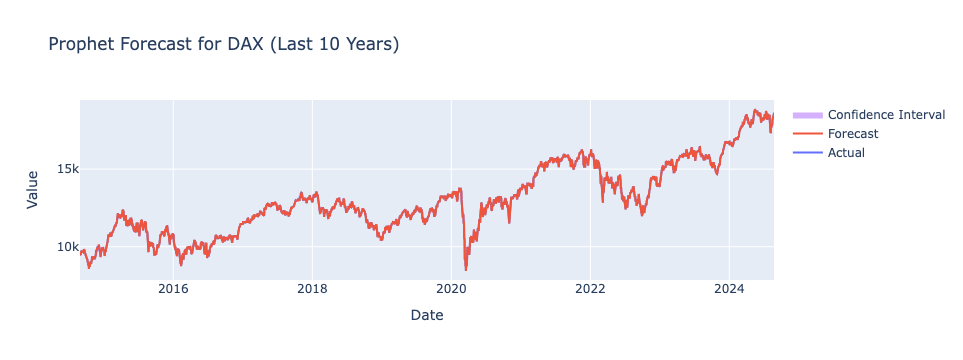

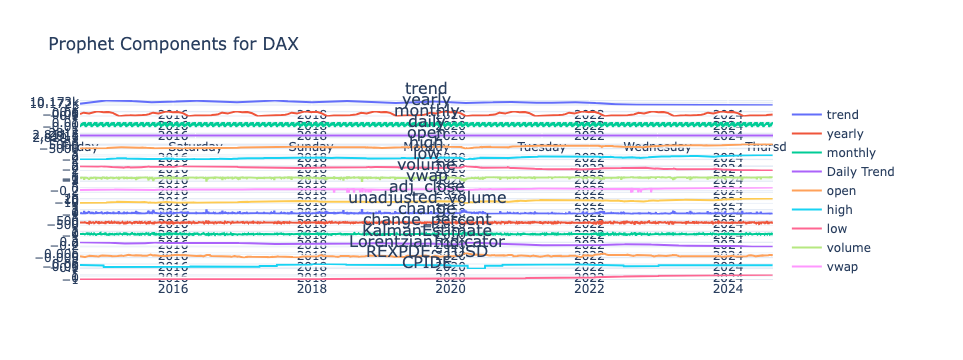


Regressor Importance:
              regressor    importance
11          REXPDE~TUSD  4.103350e-06
10  LorentzianIndicator  2.511120e-06
1                  high  2.672140e-07
0                  open  2.117290e-07
4                  vwap  1.987640e-07
2                   low  1.879990e-07
5             adj_close  1.869090e-07
12                CPIDE  1.220440e-07
3                volume  1.031160e-07
7                change  9.281980e-08
8        change_percent  7.484040e-08
6     unadjusted_volume  6.869890e-08
9        KalmanEstimate  1.725580e-08


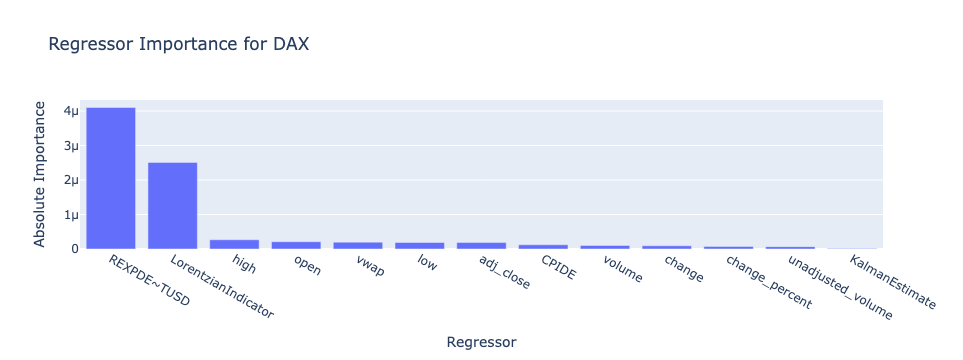

In [208]:
import pandas as pd
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime

# Load the trained model and data
df = pd.read_pickle('dax_data.pkl')
with open('prophet_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Get current date
current_date = datetime.now().date()

# Make predictions up to the current date
future = model.make_future_dataframe(periods=0)  # No future predictions
future = future.merge(df[['ds'] + [col for col in df.columns if col not in ['ds', 'y']]], on='ds', how='left')
forecast = model.predict(future)

# Evaluate the model
y_true = df['y'].values
y_pred = forecast['yhat'].values
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"\nModel Results:")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Plot the results with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', fill='tonexty', line=dict(width=0), name='Confidence Interval'))
fig.update_layout(title='Prophet Forecast for DAX (Last 10 Years)', xaxis_title='Date', yaxis_title='Value', hovermode='x unified')
fig.update_xaxes(range=[df['ds'].min(), current_date])
fig.show()

# Plot component-wise effects including daily trend
component_names = ['trend', 'yearly', 'monthly', 'daily'] + [col for col in df.columns if col not in ['ds', 'y']]
fig = make_subplots(rows=len(component_names), cols=1, subplot_titles=component_names)

for i, component in enumerate(component_names, 1):
    if component == 'daily':
        daily_trend = forecast[['ds', 'daily']].copy()  # Use .copy() to avoid SettingWithCopyWarning
        daily_trend['day_of_week'] = daily_trend['ds'].dt.day_name()
        fig.add_trace(go.Scatter(x=daily_trend['day_of_week'], y=daily_trend['daily'], mode='lines', name='Daily Trend'), row=i, col=1)
    else:
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast[component], mode='lines', name=component), row=i, col=1)

fig.update_layout(height=300*len(component_names), title_text="Prophet Components for DAX", hovermode='x unified')
fig.update_xaxes(range=[df['ds'].min(), current_date])
fig.show()

# Analyze regressor importance
if regressors:
    beta_values = model.params['beta'].flatten()
    regressor_importance = pd.DataFrame({
        'regressor': regressors,
        'importance': np.abs(beta_values[:len(regressors)])
    })
    regressor_importance = regressor_importance.sort_values('importance', ascending=False)
    print("\nRegressor Importance:")
    print(regressor_importance)

    # Plot regressor importance
    fig = go.Figure([go.Bar(x=regressor_importance['regressor'], y=regressor_importance['importance'])])
    fig.update_layout(title='Regressor Importance for DAX', xaxis_title='Regressor', yaxis_title='Absolute Importance')
    fig.show()
else:
    print("\nNo regressors were included in the model.")


## Prediction of the DAX price of the next day based on the features: Real Exports DE, Volatility (Lorentzian) mostly

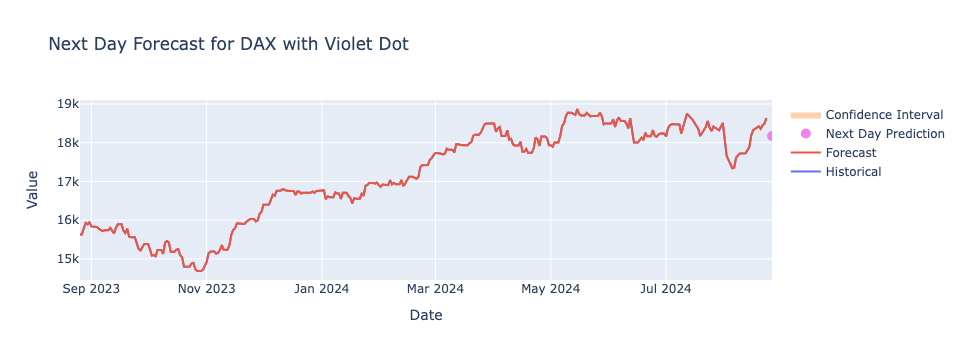


Future Prediction for the next day:
          ds          yhat    yhat_lower    yhat_upper
0 2024-08-26  18170.678657  18163.911752  18176.962993


In [216]:
import pandas as pd
import pickle
from datetime import datetime, timedelta
import plotly.graph_objects as go

# Load the trained model and data
df = pd.read_pickle('dax_data.pkl')
with open('prophet_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Get current date
current_date = datetime.now().date()

# Predict for the next day
future_dates = pd.date_range(start=current_date + timedelta(days=1), periods=1)
future_df = pd.DataFrame({'ds': future_dates})

# Initialize future_df with estimated regressor values (mean of the last 30 days)
regressors = [col for col in df.columns if col not in ['ds', 'y']]
for regressor in regressors:
    future_df[regressor] = df[regressor].tail(30).mean()

# Make the prediction for the next day
future_forecast = model.predict(future_df)

# Plot historical data and the next day's forecast with a violet dot
fig = go.Figure()

# Plot the actual historical data
fig.add_trace(go.Scatter(x=df['ds'].tail(365), y=df['y'].tail(365), mode='lines', name='Historical'))

# Plot the forecast line (without predictions)
fig.add_trace(go.Scatter(x=df['ds'].tail(365), y=model.predict(df.tail(365)[['ds'] + regressors])['yhat'], mode='lines', name='Forecast'))

# Plot the violet dot for the next day's prediction
fig.add_trace(go.Scatter(x=future_forecast['ds'], y=future_forecast['yhat'], mode='markers', name='Next Day Prediction', marker=dict(color='violet', size=10, symbol='circle')))

# Plot the confidence interval for the next day's prediction
fig.add_trace(go.Scatter(x=future_forecast['ds'], y=future_forecast['yhat_lower'], mode='lines', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=future_forecast['ds'], y=future_forecast['yhat_upper'], mode='lines', fill='tonexty', line=dict(width=0), name='Confidence Interval'))

# Update layout
fig.update_layout(title='Next Day Forecast for DAX with Violet Dot',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  hovermode='x unified')
fig.update_xaxes(range=[current_date - timedelta(days=365), future_dates[-1]])

# Show the plot
fig.show()

# Print the future prediction
print("\nFuture Prediction for the next day:")
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


## Prophet model for the next month (Swing trade)

In [248]:
from prophet import Prophet
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Assuming your dataframe is named combined_df
df = combined_df.copy()

# Convert 'index' to datetime if it's not already
df['index'] = pd.to_datetime(df['index'])

# Filter for the last 10 years of data
ten_years_ago = datetime.now() - timedelta(days=365*10)
df = df[df['index'] >= ten_years_ago]

# Remove rows with NaN values
df = df.dropna()

# Filter the data to include only the 1st day of each month
df = df[df['index'].dt.day == 1]

# Rename columns to match Prophet's requirements
df = df.rename(columns={'index': 'ds', 'close': 'y'})

# Define potential regressors (all columns except 'ds' and 'y')
regressors = [col for col in df.columns if col not in ['ds', 'y']]

def train_prophet_model(df, regressors, include_monthly_seasonality=True):
    model = Prophet(
        yearly_seasonality=True,
        daily_seasonality=False,  # Daily seasonality is unnecessary if we only have one day per month
        weekly_seasonality=False, # Weekly seasonality is unnecessary if we only have one day per month
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        seasonality_mode='additive'
    )
    
    if include_monthly_seasonality:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    for regressor in regressors:
        if regressor in df.columns:
            model.add_regressor(regressor)
    
    model.fit(df)
    return model

# Filter regressors to only include those present in the dataframe
regressors = [reg for reg in regressors if reg in df.columns]
print(f"Using regressors: {regressors}")

# Train the model
model = train_prophet_model(df, regressors)

# Save model and data for future use
df.to_pickle('dax_data_month.pkl')
import pickle
with open('prophet_model_month.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model training completed and saved.")


19:49:05 - cmdstanpy - INFO - Chain [1] start processing


Using regressors: ['open', 'high', 'low', 'volume', 'vwap', 'adj_close', 'unadjusted_volume', 'change', 'change_percent', 'KalmanEstimate', 'LorentzianIndicator', 'REXPDE~TUSD', 'CPIDE']


19:49:05 - cmdstanpy - INFO - Chain [1] done processing


Model training completed and saved.


In [249]:
df = pd.read_pickle('dax_data_month.pkl')
print(df.head(1))

             ds         open         high          low            y  \
8644 2014-09-01  9484.530273  9500.200195  9424.780273  9479.030273   

          volume        vwap    adj_close  unadjusted_volume  change  \
8644  43071900.0  9468.00358  9479.030273         43071900.0    -5.5   

      change_percent  KalmanEstimate  LorentzianIndicator  REXPDE~TUSD  CPIDE  
8644        -0.00058      9408.71774             4.904607     448849.0   94.3  


In [250]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the trained model and data
df = pd.read_pickle('dax_data_month.pkl')
with open('prophet_model_month.pkl', 'rb') as f:
    model = pickle.load(f)



Model Evaluation Results:
Root Mean Squared Error (RMSE): 0.5615036063953492
Mean Absolute Error (MAE): 0.42772182765000555


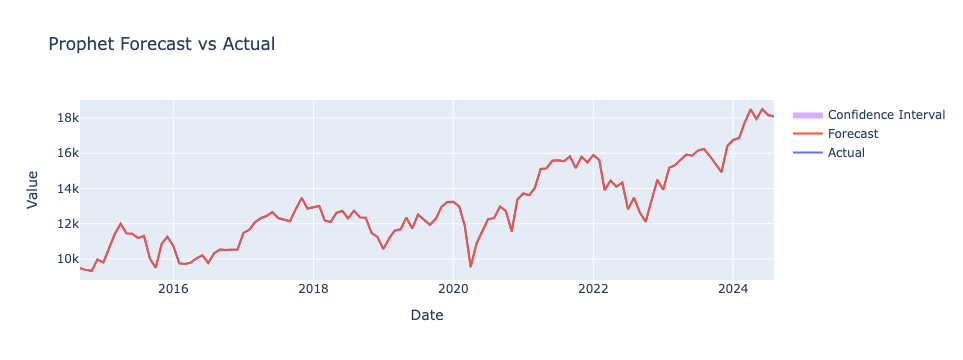

In [252]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import plotly.graph_objects as go

# Load the trained model and data
df = pd.read_pickle('dax_data_month.pkl')
with open('prophet_model_month.pkl', 'rb') as f:
    model = pickle.load(f)

# Ensure all regressors are present in the future dataframe
regressors = ['open', 'high', 'low', 'volume', 'vwap', 'adj_close', 'unadjusted_volume', 'change', 'change_percent', 'KalmanEstimate', 'LorentzianIndicator', 'REXPDE~TUSD', 'CPIDE']
future = df[['ds'] + regressors].copy()

# Make predictions on the existing data (no future dates, just evaluation)
forecast = model.predict(future)

# Extract the true values and the predicted values
y_true = df['y'].values
y_pred = forecast['yhat'].values

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Print the results
print(f"\nModel Evaluation Results:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the evaluation results with Plotly
fig = go.Figure()

# Plot the actual historical data
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Actual'))

# Plot the forecasted line
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))

# Plot the confidence interval
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', fill='tonexty', line=dict(width=0), name='Confidence Interval'))

# Update the layout
fig.update_layout(title='Prophet Forecast vs Actual',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  hovermode='x unified')

# Show the plot
fig.show()


In [253]:
import pandas as pd
import pickle
from datetime import datetime
import plotly.graph_objects as go

# Load the trained model and data
df = pd.read_pickle('dax_data_month.pkl')
with open('prophet_model_month.pkl', 'rb') as f:
    model = pickle.load(f)


In [254]:
# Make a prediction for the next first day of the month
future_dates = pd.date_range(start=datetime.now().date(), periods=1, freq='MS')  # MS = Month Start
future_df = pd.DataFrame({'ds': future_dates})

# Include all regressors, set them to a default value or use last known values
for regressor in ['open', 'high', 'low', 'volume', 'vwap', 'adj_close', 'unadjusted_volume', 'change', 'change_percent', 'KalmanEstimate', 'LorentzianIndicator', 'REXPDE~TUSD', 'CPIDE']:
    if regressor in df.columns:
        future_df[regressor] = df[regressor].iloc[-1]  # Use last known value as a simple approach

# Make the prediction
forecast = model.predict(future_df)

# Display the prediction
print("\nPrediction for the next first day of the month:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])



Prediction for the next first day of the month:
          ds          yhat    yhat_lower    yhat_upper
0 2024-09-01  18082.128156  18074.147232  18090.528226


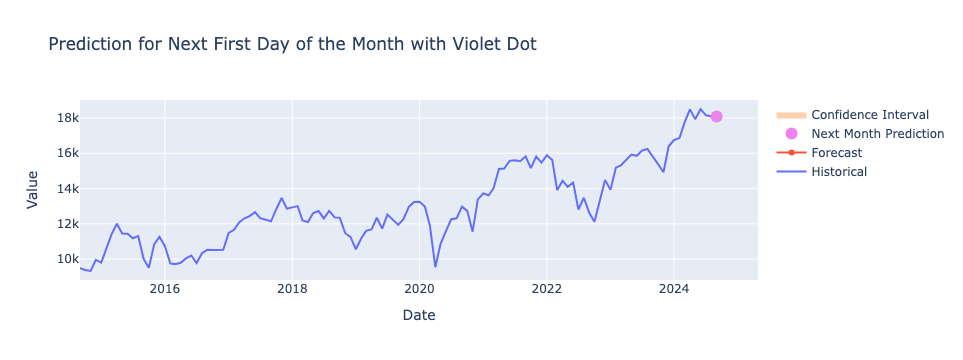

In [255]:
# Plot the historical data and forecast
fig = go.Figure()

# Plot the actual historical data
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Historical'))

# Plot the forecasted line
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines+markers', name='Forecast'))

# Add a violet dot for the next month's prediction
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='markers', name='Next Month Prediction', marker=dict(color='violet', size=12, symbol='circle')))

# Plot the confidence interval
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', fill='tonexty', line=dict(width=0), name='Confidence Interval'))

# Update the layout
fig.update_layout(title='Prediction for Next First Day of the Month with Violet Dot',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  hovermode='x unified')

# Show the plot
fig.show()


# Time-series AutoML with H2O (alternative to Prophet)

## Day range 

In [224]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle

# Initialize H2O
h2o.init()

# Assuming your dataframe is named combined_df
df = combined_df.copy()

# Convert 'index' to datetime if it's not already
df['index'] = pd.to_datetime(df['index'])
df.set_index('index', inplace=True)

# Filter for the last 10 years of data
ten_years_ago = datetime.now() - timedelta(days=365*10)
df = df[df.index >= ten_years_ago]

# Function to calculate returns for CPIDE
def calculate_cpide_returns(series, periods):
    returns = series.pct_change(periods)
    mask = returns != 0
    idx = np.arange(len(returns))
    idx_valid = idx[mask]
    returns = pd.Series(np.interp(idx, idx_valid, returns[mask]), index=returns.index)
    return returns

# Feature Engineering
for col in ['close', 'REXPDE~TUSD', 'LorentzianIndicator', 'volume']:
    df[f'{col}_lag_1'] = df[col].shift(1)
    df[f'{col}_lag_7'] = df[col].shift(7)
    df[f'{col}_lag_30'] = df[col].shift(30)
    df[f'{col}_return_1'] = df[col].pct_change(1)
    df[f'{col}_return_7'] = df[col].pct_change(7)
    df[f'{col}_return_30'] = df[col].pct_change(30)

# Special handling for CPIDE
df['CPIDE_lag_1'] = df['CPIDE'].shift(1)
df['CPIDE_lag_7'] = df['CPIDE'].shift(7)
df['CPIDE_lag_30'] = df['CPIDE'].shift(30)
df['CPIDE_return_1'] = calculate_cpide_returns(df['CPIDE'], 1)
df['CPIDE_return_7'] = calculate_cpide_returns(df['CPIDE'], 7)
df['CPIDE_return_30'] = calculate_cpide_returns(df['CPIDE'], 30)

# Remove rows with NaN values
df = df.dropna()

# Set date as a separate column for H2O
df['date'] = df.index

# Select all features except 'close' and 'date'
features = [col for col in df.columns if col not in ['close', 'date']]
target = 'close'

print("Features used:", features)
print("\nDataFrame column types:")
print(df.dtypes)

# Convert to H2OFrame
h2o_df = h2o.H2OFrame(df)

print("\nH2OFrame column types:")
print(h2o_df.types)

# Split the data into train, validation, and test sets
train, valid, test = h2o_df.split_frame(ratios=[0.7, 0.15], seed=1234)

# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600,  # 1 hour
                seed=1234,
                sort_metric='RMSE',
                stopping_rounds=20,
                stopping_tolerance=0.01,
                stopping_metric='RMSE',
                max_models=100,
                exclude_algos=['DeepLearning'],
                nfolds=0)

aml.train(x=features, y=target, training_frame=train, validation_frame=valid)

# Get the best model
best_model = aml.leader

print("\nBest model:", best_model)

# Save the model
model_path = h2o.save_model(model=best_model, path="./", force=True)
print(f"\nModel saved to: {model_path}")

# Save the DataFrame to a pickle file for later use
df.to_pickle('dax_data.pkl')
with open('model_path.txt', 'w') as f:
    f.write(model_path)

print("DataFrame and model path saved.")


Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         6 mins 46 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.4
H2O_cluster_version_age:    1 month and 15 days
H2O_cluster_name:           H2O_from_python_marius_2e9dqw
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.910 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.9 final
--------------------------  -----------------------------

Features used: ['open', 'high', 'low', 'volume', 'vwap', 'adj_close', 'unadjusted_volume', 'change', 'change_percent', 'KalmanEstimate', 'LorentzianIndicator', 'REXPDE~TUSD', 'CPIDE', 'close_lag_1', 'close_lag_7', 'close_lag_30', 'close_return_1', 'close_return_7', 'close_return_30', 'REXPDE~TUSD_lag_1', 'REXPDE~TUSD_lag_7', 'REXPDE~TUSD_lag_30', 'REXPDE~TUSD_return_1', 'REXPDE~TUSD_return_7', 'REXPDE~TUSD_return_30', 'LorentzianIndicator_lag_1', 'LorentzianIndicator_lag_7', 'LorentzianIndicator_lag_30', 'LorentzianIndicator_return_1', 'LorentzianIndicator_return_7', 'LorentzianIndicator_return_30', 'volume_lag_1', 'volume_lag_7', 'volume_lag_30', 'volume_return_1', 'volume_return_7', 'volume_return_30', 'CPIDE_lag_1', 'CPIDE_lag_7', 'CPIDE_lag_30', 'CPIDE_return_1', 'CPIDE_return_7', 'CPIDE_return_30']

DataFrame column types:
open                                    float64
high                                    float64
low                                     float64
close           

In [263]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle

# Initialize H2O
h2o.init()

# Assuming your dataframe is named combined_df
df = combined_df.copy()

# Convert 'index' to datetime if it's not already
df['index'] = pd.to_datetime(df['index'])
df.set_index('index', inplace=True)

# Filter for the last 10 years of data
ten_years_ago = datetime.now() - timedelta(days=365*10)
df = df[df.index >= ten_years_ago]

# Function to calculate returns for CPIDE
def calculate_cpide_returns(series, periods):
    returns = series.pct_change(periods)
    mask = returns != 0
    idx = np.arange(len(returns))
    idx_valid = idx[mask]
    returns = pd.Series(np.interp(idx, idx_valid, returns[mask]), index=returns.index)
    return returns

# Feature Engineering
for col in ['close', 'REXPDE~TUSD', 'LorentzianIndicator', 'volume']:
    df[f'{col}_lag_1'] = df[col].shift(1)
    df[f'{col}_lag_7'] = df[col].shift(7)
    df[f'{col}_lag_30'] = df[col].shift(30)
    df[f'{col}_return_1'] = df[col].pct_change(1)
    df[f'{col}_return_7'] = df[col].pct_change(7)
    df[f'{col}_return_30'] = df[col].pct_change(30)

# Special handling for CPIDE
df['CPIDE_lag_1'] = df['CPIDE'].shift(1)
df['CPIDE_lag_7'] = df['CPIDE'].shift(7)
df['CPIDE_lag_30'] = df['CPIDE'].shift(30)
df['CPIDE_return_1'] = calculate_cpide_returns(df['CPIDE'], 1)
df['CPIDE_return_7'] = calculate_cpide_returns(df['CPIDE'], 7)
df['CPIDE_return_30'] = calculate_cpide_returns(df['CPIDE'], 30)

# Remove rows with NaN values
df = df.dropna()

# Set date as a separate column for H2O
df['date'] = df.index

# Ensure data types
df['volume_return_7'] = df['volume_return_7'].astype('float')

# Select all features except 'close' and 'date'
features = [col for col in df.columns if col not in ['close', 'date']]
target = 'close'

# Convert to H2OFrame
h2o_df = h2o.H2OFrame(df)

# Split the data into train, validation, and test sets
train, valid, test = h2o_df.split_frame(ratios=[0.7, 0.15], seed=1234)

# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600,  # 1 hour
                seed=1234,
                sort_metric='RMSE',
                stopping_rounds=20,
                stopping_tolerance=0.01,
                stopping_metric='RMSE',
                max_models=100,
                exclude_algos=['DeepLearning'],
                nfolds=0)

aml.train(x=features, y=target, training_frame=train, validation_frame=valid)

# Get the best model
best_model = aml.leader

# Save the model
model_path = h2o.save_model(model=best_model, path="./", force=True)
print(f"\nModel saved to: {model_path}")

# Save the DataFrame to a pickle file for later use
df.to_pickle('dax_data.pkl')
with open('model_path.txt', 'w') as f:
    f.write(model_path)

print("DataFrame and model path saved.")


Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         42 mins 19 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.4
H2O_cluster_version_age:    1 month and 15 days
H2O_cluster_name:           H2O_from_python_marius_2e9dqw
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.498 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.9 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:00:35.757: Stopping tolerance set by the user is < 70% of the recommended default of 0.01989286700048564, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%

Model saved to: /home/marius/finance_code/GBM_grid_1_AutoML_2_20240825_200035_model_10
DataFrame and model path saved.


In [264]:
import h2o
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize H2O
h2o.init()

# Load the trained model and data
df = pd.read_pickle('dax_data.pkl')
model_path = open('model_path.txt', 'r').read().strip()
best_model = h2o.load_model(model_path)

# Convert the DataFrame to an H2OFrame
h2o_df = h2o.H2OFrame(df)

# Split the data back into train, validation, and test sets
train, valid, test = h2o_df.split_frame(ratios=[0.7, 0.15], seed=1234)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         54 mins 08 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.4
H2O_cluster_version_age:    1 month and 16 days
H2O_cluster_name:           H2O_from_python_marius_2e9dqw
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.150 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.9 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [265]:
# Generate predictions on the validation set
predictions = best_model.predict(valid)

# Convert H2OFrame to Pandas DataFrame
y_true = valid['close'].as_data_frame().values.flatten()  # Actual values
y_pred = predictions.as_data_frame().values.flatten()      # Predicted values

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Print the evaluation metrics
print(f"\nModel Evaluation Results on Validation Set:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/marius/miniconda3/envs/openbb/lib/python3.11/site-packages/h2o/frame.py:1981: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)





Model Evaluation Results on Validation Set:
Root Mean Squared Error (RMSE): 6.293713231950466
Mean Absolute Error (MAE): 2.7922842229304963


/home/marius/miniconda3/envs/openbb/lib/python3.11/site-packages/h2o/frame.py:1981: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)




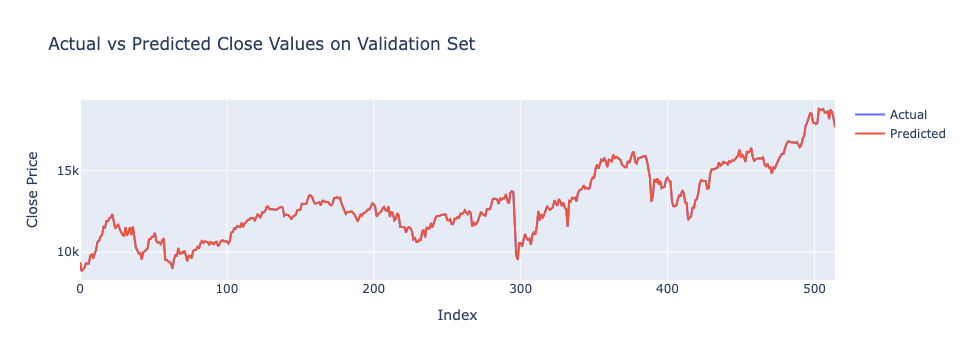

In [266]:
import plotly.graph_objects as go

# Create a plot to visualize the predictions vs actual values
fig = go.Figure()

# Plot the actual values
fig.add_trace(go.Scatter(x=np.arange(len(y_true)), y=y_true, mode='lines', name='Actual'))

# Plot the predicted values
fig.add_trace(go.Scatter(x=np.arange(len(y_pred)), y=y_pred, mode='lines', name='Predicted'))

# Update layout
fig.update_layout(title='Actual vs Predicted Close Values on Validation Set',
                  xaxis_title='Index',
                  yaxis_title='Close Price',
                  hovermode='x unified')

# Show the plot
fig.show()


In [268]:
# Ensure 'volume_return_7' is correctly set as a float
next_day_df['volume_return_7'] = next_day_df['volume_return_7'].astype('float')

# Ensure all other columns match their training data types
for col in next_day_df.columns:
    if training_types[col] == 'enum':  # If the column was treated as categorical during training
        next_day_df[col] = next_day_df[col].astype('category')
    elif training_types[col] == 'real':  # If the column was treated as real (float) during training
        next_day_df[col] = next_day_df[col].astype('float')
    elif training_types[col] == 'int':  # If the column was treated as integer during training
        next_day_df[col] = next_day_df[col].astype('int')


In [269]:
# Convert the DataFrame to an H2OFrame
next_day_h2o = h2o.H2OFrame(next_day_df)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [271]:
import h2o
import pandas as pd

# Load the DataFrame and model
df = pd.read_pickle('dax_data.pkl')

# Convert the DataFrame to an H2OFrame
h2o_df = h2o.H2OFrame(df)

# Print data types to confirm
print("\nH2OFrame column types:")
print(h2o_df.types)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

H2OFrame column types:
{'open': 'real', 'high': 'real', 'low': 'real', 'close': 'real', 'volume': 'int', 'vwap': 'real', 'adj_close': 'real', 'unadjusted_volume': 'int', 'change': 'real', 'change_percent': 'real', 'KalmanEstimate': 'real', 'LorentzianIndicator': 'real', 'REXPDE~TUSD': 'int', 'CPIDE': 'real', 'close_lag_1': 'real', 'close_lag_7': 'real', 'close_lag_30': 'real', 'close_return_1': 'real', 'close_return_7': 'real', 'close_return_30': 'real', 'REXPDE~TUSD_lag_1': 'int', 'REXPDE~TUSD_lag_7': 'int', 'REXPDE~TUSD_lag_30': 'int', 'REXPDE~TUSD_return_1': 'real', 'REXPDE~TUSD_return_7': 'real', 'REXPDE~TUSD_return_30': 'real', 'LorentzianIndicator_lag_1': 'real', 'LorentzianIndicator_lag_7': 'real', 'LorentzianIndicator_lag_30': 'real', 'LorentzianIndicator_return_1': 'real', 'LorentzianIndicator_return_7': 'real', 'LorentzianIndicator_return_30': 'real', 'volume_lag_1': 'int', 'volume

In [272]:
import h2o
import pandas as pd
from datetime import datetime, timedelta

# Prepare the data for the next day prediction
last_row = df.iloc[-1].copy()

# Increment the date to predict for the next day
next_day = last_row['date'] + timedelta(days=1)
last_row['date'] = next_day

# Convert to DataFrame
next_day_df = pd.DataFrame([last_row])

# Ensure 'volume_return_7' and all similar columns are set as float
next_day_df['volume_return_7'] = next_day_df['volume_return_7'].astype('float')

# Convert the DataFrame to an H2OFrame with specified types
types_dict = {
    'open': 'real',
    'high': 'real',
    'low': 'real',
    'close': 'real',
    'volume': 'int',
    'vwap': 'real',
    'adj_close': 'real',
    'unadjusted_volume': 'int',
    'change': 'real',
    'change_percent': 'real',
    'KalmanEstimate': 'real',
    'LorentzianIndicator': 'real',
    'REXPDE~TUSD': 'int',
    'CPIDE': 'real',
    'close_lag_1': 'real',
    'close_lag_7': 'real',
    'close_lag_30': 'real',
    'close_return_1': 'real',
    'close_return_7': 'real',
    'close_return_30': 'real',
    'REXPDE~TUSD_lag_1': 'int',
    'REXPDE~TUSD_lag_7': 'int',
    'REXPDE~TUSD_lag_30': 'int',
    'REXPDE~TUSD_return_1': 'real',
    'REXPDE~TUSD_return_7': 'real',
    'REXPDE~TUSD_return_30': 'real',
    'LorentzianIndicator_lag_1': 'real',
    'LorentzianIndicator_lag_7': 'real',
    'LorentzianIndicator_lag_30': 'real',
    'LorentzianIndicator_return_1': 'real',
    'LorentzianIndicator_return_7': 'real',
    'LorentzianIndicator_return_30': 'real',
    'volume_lag_1': 'int',
    'volume_lag_7': 'int',
    'volume_lag_30': 'int',
    'volume_return_1': 'real',
    'volume_return_7': 'real',
    'volume_return_30': 'real',
    'CPIDE_lag_1': 'real',
    'CPIDE_lag_7': 'real',
    'CPIDE_lag_30': 'real',
    'CPIDE_return_1': 'real',
    'CPIDE_return_7': 'real',
    'CPIDE_return_30': 'real',
    'date': 'time'
}

# Convert the DataFrame to an H2OFrame with explicitly specified column types
next_day_h2o = h2o.H2OFrame(next_day_df, column_types=types_dict)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [273]:
# Predict the 'close' value for the next day
try:
    prediction = best_model.predict(next_day_h2o)
    predicted_close = prediction.as_data_frame().iloc[0, 0]
    print(f"Prediction for {next_day.date()}: {predicted_close}")
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prediction for 2024-08-24: 18633.202683363976


/home/marius/miniconda3/envs/openbb/lib/python3.11/site-packages/h2o/frame.py:1981: H2ODependencyWarning:

Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)




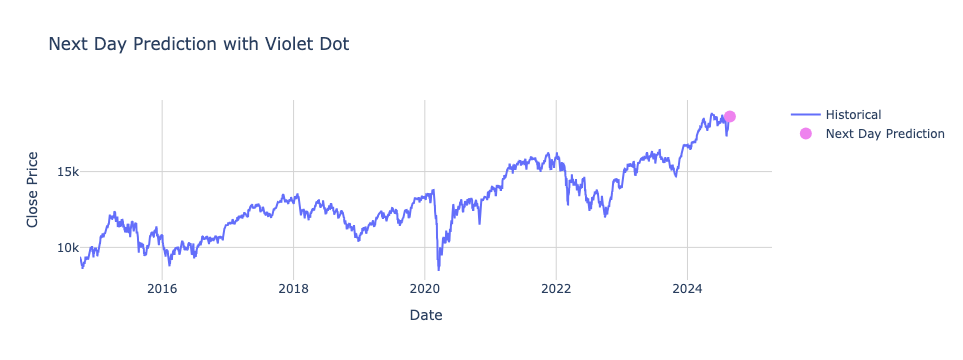

In [274]:
import plotly.graph_objects as go

# Historical data
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['close'], mode='lines', name='Historical'))

# Plot the prediction with a violet dot
fig.add_trace(go.Scatter(x=[next_day], y=[predicted_close], mode='markers', name='Next Day Prediction', marker=dict(color='violet', size=12, symbol='circle')))

# Update layout for better style
fig.update_layout(
    title='Next Day Prediction with Violet Dot',
    xaxis_title='Date',
    yaxis_title='Close Price',
    hovermode='x unified',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray')
)

# Show the plot
fig.show()


# Kalman estimate (high, low, close)

Useful for stop-loss and take-profit estimation.

In [149]:
df = combined_df.iloc[-365:]
print(df.dtypes)

index                  datetime64[ns]
open                          float64
high                          float64
low                           float64
close                         float64
volume                        float64
vwap                          float64
adj_close                     float64
unadjusted_volume             float64
change                        float64
change_percent                float64
KalmanEstimate                float64
LorentzianIndicator           float64
REXPDE~TUSD                   float64
CPIDE                         float64
dtype: object


In [150]:
print(df.head(1))

           index      open      high       low     close      volume  \
11911 2023-08-12  15927.79  15962.45  15803.08  15832.17  60296700.0   

           vwap  adj_close  unadjusted_volume  change  change_percent  \
11911  15881.37   15832.17         60296700.0  -95.62       -0.006003   

       KalmanEstimate  LorentzianIndicator  REXPDE~TUSD  CPIDE  
11911    16021.801098             5.274866     441556.0  117.5  


In [151]:
print(df.index.dtype)

int64


In [159]:
import numpy as np
from pykalman import KalmanFilter

# Assuming df is your DataFrame with a 'close' column

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Filter the data
filtered_state_means, filtered_state_covariances = kf.filter(df['close'])

# Get the last filtered state
last_state_mean = filtered_state_means[-1]
last_state_covariance = filtered_state_covariances[-1]

# Predict the next state
next_state_mean, next_state_covariance = kf.filter_update(
    filtered_state_mean=last_state_mean,
    filtered_state_covariance=last_state_covariance
)

print(f"Estimate for the next value: {next_state_mean[0]}")

Estimate for the next value: 18199.13689976488


In [160]:
import numpy as np
from pykalman import KalmanFilter

# Assuming df is your DataFrame with a 'close' column

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['high'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Filter the data
filtered_state_means, filtered_state_covariances = kf.filter(df['high'])

# Get the last filtered state
last_state_mean = filtered_state_means[-1]
last_state_covariance = filtered_state_covariances[-1]

# Predict the next state
next_state_mean, next_state_covariance = kf.filter_update(
    filtered_state_mean=last_state_mean,
    filtered_state_covariance=last_state_covariance
)

print(f"Estimate for the next value: {next_state_mean[0]}")

Estimate for the next value: 18271.87958586028


In [161]:
import numpy as np
from pykalman import KalmanFilter

# Assuming df is your DataFrame with a 'close' column

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Filter the data
filtered_state_means, filtered_state_covariances = kf.filter(df['close'])

# Get the last filtered state
last_state_mean = filtered_state_means[-1]
last_state_covariance = filtered_state_covariances[-1]

# Predict the next state
next_state_mean, next_state_covariance = kf.filter_update(
    filtered_state_mean=last_state_mean,
    filtered_state_covariance=last_state_covariance
)

print(f"Estimate for the next value: {next_state_mean[0]}")

Estimate for the next value: 18199.13689976488


# Buy / sell signals for the Dax

In [162]:
import pandas as pd
import numpy as np
import talib as ta

In [173]:
df = combined_df.iloc[-365:].copy()
print(df.dtypes)


open                   float64
high                   float64
low                    float64
close                  float64
volume                 float64
vwap                   float64
adj_close              float64
unadjusted_volume      float64
change                 float64
change_percent         float64
KalmanEstimate         float64
LorentzianIndicator    float64
REXPDE~TUSD            float64
CPIDE                  float64
dtype: object


In [164]:
def ma(ma_type, src, length, volume=None):
    if ma_type == 'SMA':
        return ta.SMA(src, timeperiod=length)
    elif ma_type == 'EMA':
        return ta.EMA(src, timeperiod=length)
    elif ma_type == 'DEMA':
        return ta.DEMA(src, timeperiod=length)
    elif ma_type == 'TEMA':
        return ta.TEMA(src, timeperiod=length)
    elif ma_type == 'WMA':
        return ta.WMA(src, timeperiod=length)
    elif ma_type == 'VWMA':
        if volume is None:
            raise ValueError("Volume data is required for VWMA")
        return ta.SMA(src * volume, timeperiod=length) / ta.SMA(volume, timeperiod=length)
    elif ma_type == 'SMMA':
        return ta.SMA(src, timeperiod=length)
    elif ma_type == 'HMA':
        return ta.WMA(2 * ta.WMA(src, timeperiod=length // 2) - ta.WMA(src, timeperiod=length), timeperiod=int(np.sqrt(length)))
    elif ma_type == 'LSMA':
        return ta.LINEARREG(src, timeperiod=length)
    elif ma_type == 'PEMA':
        ema1 = ta.EMA(src, timeperiod=length)
        ema2 = ta.EMA(ema1, timeperiod=length)
        ema3 = ta.EMA(ema2, timeperiod=length)
        ema4 = ta.EMA(ema3, timeperiod=length)
        ema5 = ta.EMA(ema4, timeperiod=length)
        ema6 = ta.EMA(ema5, timeperiod=length)
        ema7 = ta.EMA(ema6, timeperiod=length)
        ema8 = ta.EMA(ema7, timeperiod=length)
        return 8 * ema1 - 28 * ema2 + 56 * ema3 - 70 * ema4 + 56 * ema5 - 28 * ema6 + 8 * ema7 - ema8
    else:
        raise ValueError(f"Unknown MA Type: {ma_type}")


In [165]:
def kalman_filter(df, sharpness, k_period):
    df.loc[:, 'kfilt'] = 0.0
    df.loc[:, 'velocity'] = 0.0
    for i in range(1, len(df)):
        distance = df['close'].iloc[i] - df['kfilt'].iloc[i - 1]
        error = df['kfilt'].iloc[i - 1] + distance * np.sqrt(sharpness * k_period / 100)
        velocity = df['velocity'].iloc[i - 1] + distance * k_period / 100
        df.loc[df.index[i], 'kfilt'] = error + velocity
        df.loc[df.index[i], 'velocity'] = velocity
    return df['kfilt']


In [166]:
def calculate_roc(df, length):
    return ta.ROC(df['kfilt'], timeperiod=length)


In [167]:
def calculate_stochastic(df, periodK, smoothK, periodD):
    k, d = ta.STOCH(df['high'], df['low'], df['close'],
                    fastk_period=periodK,
                    slowk_period=smoothK, 
                    slowk_matype=0,
                    slowd_period=periodD,
                    slowd_matype=0)
    return k, d


In [168]:
def calculate_blend(df, ma_type, smoothlen):
    roc = calculate_roc(df, length=9)  # Assuming length=9
    _, d = calculate_stochastic(df, periodK=14, smoothK=1, periodD=3)  # Default values
    blend = (roc + d) / 2
    blend = ma(ma_type, blend, smoothlen)
    blend = blend.dropna()  # Drop NaN values that could arise from insufficient data
    return blend


In [169]:
def generate_signals(df, blend):
    df.loc[:, 'buy_signal'] = np.where((blend > blend.shift(1)) & (blend.shift(1) <= blend.shift(2)), 1, 0)
    df.loc[:, 'sell_signal'] = np.where((blend < blend.shift(1)) & (blend.shift(1) >= blend.shift(2)), 1, 0)
    return df


In [170]:
def analyze(df, ma_type='TEMA', smoothlen=12, sharpness=25.0, k_period=1.0):
    df['kfilt'] = kalman_filter(df, sharpness, k_period)
    blend = calculate_blend(df, ma_type, smoothlen)
    df['blend'] = blend
    df = generate_signals(df, blend)
    df = df.dropna(subset=['blend'])  # Drop rows where 'blend' is NaN
    return df[['buy_signal', 'sell_signal']]  # Return only the buy and sell signals


In [174]:
# Analyze and print only the buy and sell signals
signal_df = analyze(df)
print(signal_df)


                    open          high           low         close  \
2023-08-19  15597.120000  15612.880000  15468.650000  15574.260000   
2023-08-20  15597.120000  15612.880000  15468.650000  15574.260000   
2023-08-21  15573.950000  15710.210000  15571.820000  15603.280000   
2023-08-22  15684.640000  15799.340000  15677.440000  15705.620000   
2023-08-23  15761.250000  15820.950000  15672.430000  15728.410000   
...                  ...           ...           ...           ...   
2024-08-26  18470.006463  18582.574769  18450.405407  18537.821152   
2024-08-27  18470.149396  18582.209304  18451.668874  18537.641506   
2024-08-28  18470.316624  18582.192740  18451.403439  18537.936833   
2024-08-29  18470.645896  18583.090019  18451.158720  18538.491185   
2024-08-30  18471.650998  18582.831214  18451.680800  18538.901426   

                  volume          vwap     adj_close  unadjusted_volume  \
2023-08-19  5.990950e+07  15563.230000  15574.260000       5.990950e+07   
2023-08-2

In [175]:
import plotly.graph_objs as go
import plotly.express as px

# Example: Assuming 'df' is the DataFrame after analysis and contains the 'buy_signal' and 'sell_signal' columns
# and 'close' column to plot the price



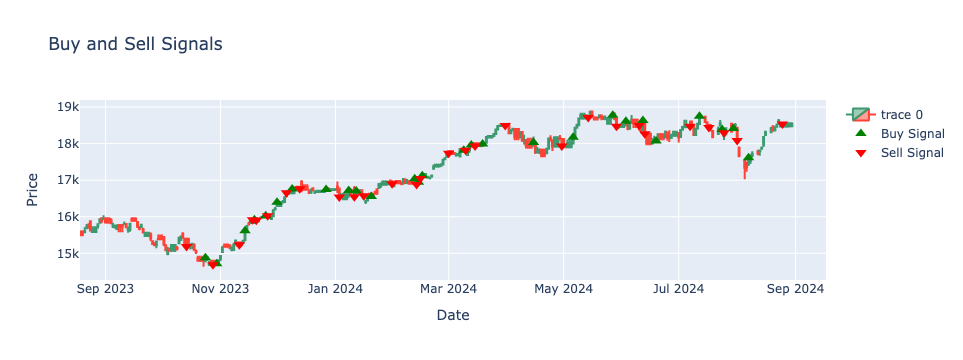

In [176]:
def plot_signals(df):
    # Create a candlestick chart
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])])

    # Add Buy signals as green up arrows
    buy_signals = df[df['buy_signal'] == 1]
    fig.add_trace(go.Scatter(x=buy_signals.index,
                             y=buy_signals['close'],
                             mode='markers',
                             marker=dict(symbol='triangle-up', color='green', size=10),
                             name='Buy Signal'))

    # Add Sell signals as red down arrows
    sell_signals = df[df['sell_signal'] == 1]
    fig.add_trace(go.Scatter(x=sell_signals.index,
                             y=sell_signals['close'],
                             mode='markers',
                             marker=dict(symbol='triangle-down', color='red', size=10),
                             name='Sell Signal'))

    # Update layout for better visuals
    fig.update_layout(title='Buy and Sell Signals',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      xaxis_rangeslider_visible=False)

    # Show the plot
    fig.show()

# Assuming signal_df contains the 'buy_signal' and 'sell_signal' columns along with price data
plot_signals(df)


In [177]:
def get_signal_list(df):
    # Create an empty list to store the signals
    signals = []
    
    # Iterate through the DataFrame and check for buy and sell signals
    for index, row in df.iterrows():
        if row['buy_signal'] == 1:
            signals.append({'Date': index, 'Signal': 'Buy', 'Price': row['close']})
        elif row['sell_signal'] == 1:
            signals.append({'Date': index, 'Signal': 'Sell', 'Price': row['close']})
    
    return signals


In [178]:
# Assuming df contains the 'buy_signal' and 'sell_signal' columns
signal_list = get_signal_list(df)

# Display the signal list
for signal in signal_list:
    print(f"Date: {signal['Date']}, Signal: {signal['Signal']}, Price: {signal['Price']}")


Date: 2023-10-14 00:00:00, Signal: Sell, Price: 15186.66016
Date: 2023-10-24 00:00:00, Signal: Buy, Price: 14879.94043
Date: 2023-10-28 00:00:00, Signal: Sell, Price: 14687.41016
Date: 2023-10-30 00:00:00, Signal: Buy, Price: 14716.54004
Date: 2023-11-11 00:00:00, Signal: Sell, Price: 15234.38965
Date: 2023-11-14 00:00:00, Signal: Buy, Price: 15614.42969
Date: 2023-11-18 00:00:00, Signal: Sell, Price: 15919.16016
Date: 2023-11-19 00:00:00, Signal: Buy, Price: 15919.16016
Date: 2023-11-20 00:00:00, Signal: Sell, Price: 15901.33008
Date: 2023-11-25 00:00:00, Signal: Buy, Price: 16029.49023
Date: 2023-11-26 00:00:00, Signal: Sell, Price: 16029.49023
Date: 2023-12-01 00:00:00, Signal: Buy, Price: 16397.51953
Date: 2023-12-06 00:00:00, Signal: Sell, Price: 16656.43945
Date: 2023-12-09 00:00:00, Signal: Buy, Price: 16759.2207
Date: 2023-12-13 00:00:00, Signal: Sell, Price: 16766.05078
Date: 2023-12-27 00:00:00, Signal: Buy, Price: 16742.07031
Date: 2024-01-03 00:00:00, Signal: Sell, Price: 1

## Backtest

In [191]:
initial_depot = 10000  # Initial depot in Euros
depot = initial_depot  # Current depot value
position_size_percentage = 0.03   # 3% of the depot for each trade
stop_loss_points = 100  # Stop loss of 100 points
dax_data = df['close']  # Assuming 'close' is the DAX price column

# Generate the signal list as in the previous steps
signal_list = get_signal_list(df)


In [192]:
from datetime import timedelta

# Initialize variables
current_position = None  # Track whether in a buy or sell position
entry_price = None  # Track the price at which the position was entered
entry_date = None  # Track the date at which the position was entered
results = []  # Store results of each trade

for signal in signal_list:
    signal_date = signal['Date']
    signal_type = signal['Signal']
    signal_price = signal['Price']
    
    if signal_type == 'Buy':
        if current_position is None:  # Enter a new long position
            position_size = depot * position_size_percentage
            entry_price = signal_price
            entry_date = signal_date
            current_position = 'long'
            results.append({
                'Date': signal_date,
                'Action': 'Buy',
                'Entry Price': entry_price,
                'Position Size': position_size,
                'Depot': depot
            })
    
    elif signal_type == 'Sell':
        if current_position == 'long':  # Exit the long position
            profit = (signal_price - entry_price) * (position_size / entry_price)
            depot += profit
            results.append({
                'Date': signal_date,
                'Action': 'Sell',
                'Exit Price': signal_price,
                'Profit': profit,
                'Depot': depot
            })
            current_position = None
    
    # Implement stop loss logic
    if current_position == 'long' and signal_price <= entry_price - stop_loss_points:
        # Sell the position if stop loss is hit
        loss = (entry_price - (entry_price - stop_loss_points)) * (position_size / entry_price)
        depot -= loss
        results.append({
            'Date': signal_date,
            'Action': 'Stop Loss Triggered',
            'Exit Price': entry_price - stop_loss_points,
            'Loss': loss,
            'Depot': depot
        })
        current_position = None
    
    # Automatically close the position after 2 days
    if current_position == 'long' and (signal_date - entry_date).days >= 2:
        profit = (signal_price - entry_price) * (position_size / entry_price)
        depot += profit
        results.append({
            'Date': signal_date,
            'Action': 'Auto Close After 2 Days',
            'Exit Price': signal_price,
            'Profit': profit,
            'Depot': depot
        })
        current_position = None


In [193]:
# Display the results
for trade in results:
    profit_loss = trade.get('Profit', trade.get('Loss', 'N/A'))
    # Only format profit_loss if it's a number
    if isinstance(profit_loss, (int, float)):
        profit_loss = f"{profit_loss:.2f}"
    
    print(f"Date: {trade['Date']}, Action: {trade['Action']}, "
          f"Entry Price: {trade.get('Entry Price', 'N/A')}, "
          f"Exit Price: {trade.get('Exit Price', 'N/A')}, "
          f"Profit/Loss: {profit_loss}, "
          f"Depot: {trade['Depot']:.2f}")

# Print the final depot value
print(f"\nFinal Depot Value: {depot:.2f} Euros")


Date: 2023-10-24 00:00:00, Action: Buy, Entry Price: 14879.94043, Exit Price: N/A, Profit/Loss: N/A, Depot: 10000.00
Date: 2023-10-28 00:00:00, Action: Sell, Entry Price: N/A, Exit Price: 14687.41016, Profit/Loss: -3.88, Depot: 9996.12
Date: 2023-10-30 00:00:00, Action: Buy, Entry Price: 14716.54004, Exit Price: N/A, Profit/Loss: N/A, Depot: 9996.12
Date: 2023-11-11 00:00:00, Action: Sell, Entry Price: N/A, Exit Price: 15234.38965, Profit/Loss: 10.55, Depot: 10006.67
Date: 2023-11-14 00:00:00, Action: Buy, Entry Price: 15614.42969, Exit Price: N/A, Profit/Loss: N/A, Depot: 10006.67
Date: 2023-11-18 00:00:00, Action: Sell, Entry Price: N/A, Exit Price: 15919.16016, Profit/Loss: 5.86, Depot: 10012.53
Date: 2023-11-19 00:00:00, Action: Buy, Entry Price: 15919.16016, Exit Price: N/A, Profit/Loss: N/A, Depot: 10012.53
Date: 2023-11-20 00:00:00, Action: Sell, Entry Price: N/A, Exit Price: 15901.33008, Profit/Loss: -0.34, Depot: 10012.19
Date: 2023-11-25 00:00:00, Action: Buy, Entry Price: 16